In [1]:
# loading the dataset
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

df = pd.read_json('Microblog_Trainingdata.json.txt')

In [2]:
# printing dataset sample
print(len(df))
with pd.option_context('display.width', None, 'max_colwidth', 1000, 'max_rows', None):
    display(df.sample(10, random_state=31434))

1700


,source,cashtag,sentiment score,id,spans
353,twitter,$WYNN,0.489,709499794910109696,[buy $WYNN]
1014,twitter,$DORM,0.414,719732320404709376,[TOP 5 STOCK PICKS]
215,stocktwits,$DGAZ,0.331,29835080,"[Looks like that support line around 24.90 held, t can close green it could start seeing some pstv momentum,]"
560,twitter,$HAR,0.454,708355634857529344,[Sector Stocks Leading Today]
80,stocktwits,$FCX,0.339,5514207,[$FCX +3.53%]
770,twitter,$CJES,-0.438,709834259687710720,[Biggest Market Losers]
23,stocktwits,$CHK,0.279,5364581,[reserves are in decline]
1051,twitter,$MAR,0.336,711907079296933888,[Unusual call buying]
1695,stocktwits,$RIMM,-0.126,7442585,[So both call/put buyers are crushed]
1205,twitter,$PYPL,-0.113,719542623279702016,[Barclays signs on to Apple Pay]


In [3]:
# exploring source field values
df.source.value_counts()

stocktwits    934
twitter       766
Name: source, dtype: int64

In [4]:
# exploring cashtag field values
df.cashtag.value_counts()

$AAPL    117
$TSLA     80
$FB       77
$SPY      60
$AMZN     30
        ... 
$GG        1
$WNR       1
$MMM       1
$HA        1
$OSTK      1
Name: cashtag, Length: 684, dtype: int64

0.1145229411764706


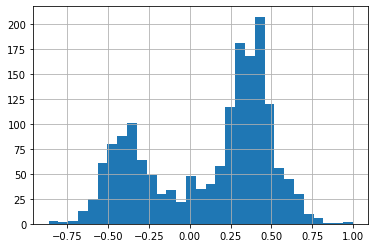

In [5]:
# exploring sentiment score distribution
# we see two clusters and bigger positive one
print(df['sentiment score'].mean())
df['sentiment score'].hist(bins=31)

In [6]:
# exploring id field values
df.id.value_counts()

39047349              13
719535506980265984    11
719520125582503936    10
708355634857529344     9
709834259687710720     8
                      ..
26057981               1
719532953642999808     1
9942259                1
9694450                1
12799689               1
Name: id, Length: 1229, dtype: int64

In [7]:
# exploring number of spans
df.spans.str.len().value_counts()

1    1378
2     272
3      45
4       4
5       1
Name: spans, dtype: int64

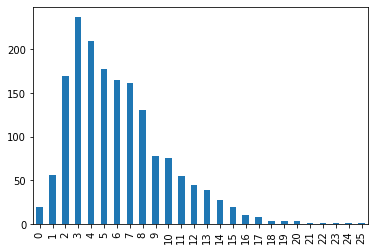

In [8]:
# exploring word counts - rather short texts
df.spans.str.join(' ').str.split().str.len().value_counts(sort=False).plot.bar()

In [9]:
# exploring frequent phrases, notice some empty and finincial slang
df.spans.str.join(', ').value_counts()

                                                                  20
Stochastic Overbought                                             13
Unusual Call Activity                                             12
Nice day rally!                                                   11
downgrade                                                         10
                                                                  ..
Took Small posistion on $TSLA                                      1
wouldn't be surprised to see a green close                         1
cash & cheap financing is fueling a wave of acquisitions           1
bumping its head on declining daily 8ma as overhead resistance     1
staying strong                                                     1
Name: spans, Length: 1252, dtype: int64

In [10]:
# part of installation - download needed nltk corpora
import nltk


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
# check out most common words, notice lot's of financial jargon
from collections import Counter
from nltk.corpus import stopwords


stop_words = set(stopwords.words('english'))
Counter((w
         for w in ' '.join(df.spans.str.join(' ')).lower().split()
         if w not in stop_words)
       ).most_common()[:20]

[('stocks', 80),
 ('long', 73),
 ('buy', 70),
 ('short', 65),
 ('today', 51),
 ('good', 46),
 ('nice', 44),
 ('new', 44),
 ('looking', 43),
 ('still', 43),
 ('stock', 41),
 ('market', 37),
 ('day', 36),
 ('bullish', 35),
 ('top', 34),
 ('call', 32),
 ('like', 31),
 ('week', 28),
 ('looks', 27),
 ('trade', 26)]

Found main paper about this dataset when googling tweets:  
https://www.aclweb.org/anthology/S17-2089.pdf

The table with top papers, some with code. Score is not directly comparable because we use cross-validation and they test on a separate dataset. Anyway it's good to stick with their metric. Ideas of Jiang, Ghosal and Cabanski were used in this work.

|rank|score|author|paper|code|
|-|-|-|-|-|
|1|0.778|Jiang|https://www.aclweb.org/anthology/S17-2152.pdf ||
|2|0.751|Ghosal|https://www.aclweb.org/anthology/S17-2154.pdf ||
|3|0.735|Deborah| https://www.aclweb.org/anthology/S17-2139.pdf ||
|4|0.730|Cabanski| https://www.aclweb.org/anthology/S17-2141.pdf | https://github.com/tocab/SemEval2017Task5
|5|0.726|Kumar| https://www.aclweb.org/anthology/S17-2153.pdf ||
|6|0.723|Kar| http://sudiptakar.info/wp-content/uploads/2018/02/semeval2017task5.pdf | https://github.com/cryptexcode/SemEval-2017-Task-5 |
|7|0.720|Nasim| https://www.aclweb.org/anthology/S17-2140.pdf ||
|8|0.707|Seyeditabari|https://www.aclweb.org/anthology/S17-2146.pdf ||
|9|0.693|Saleiro| https://arxiv.org/pdf/1704.05091.pdf | https://github.com/saleiro/SemEval2017-Task5 |

In [12]:
# saving cross-validation splits for reproducible result
# we split by id because unlikely we will see the same tweets in test dataset
# this actually makes a couple percent difference with random split and some papers missed it

from sklearn.model_selection import GroupKFold
import pickle


try:
    with open('splits.pkl', 'rb') as f:
        splits = pickle.load(f)
    print('loaded splits')
except:
    split = GroupKFold(n_splits=5)
    splits = list(split.split(df, groups=df.id))
    with open('splits.pkl', 'wb') as f:
        pickle.dump(splits, f, protocol=pickle.HIGHEST_PROTOCOL)
    print('saved splits')

loaded splits


In [13]:
# we consider both regression to compare to papers and classification as stated in this task
# we predict continous y and consider y > 0 as positive and y <=0 as negative
# accuracy - as usual
# cosine - cosine distance from papers
# binary_cosine - similarly to cosine but for classification and calibrated to have max=1 achiveable

from sklearn.metrics import accuracy_score
import scipy


def main_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true > 0, y_pred > 0),
        'cosine': 1 - scipy.spatial.distance.cosine(y_true, y_pred),
        'binary_cosine': np.dot(y_true, (y_pred > 0) * 2 - 1) / np.sum(np.abs(y_true)),
    }

In [14]:
# main function that does cross-validation and
# calls solve function inside that accepts train and test dataframes
from tqdm import tqdm_notebook as tqdm


def cross_validate(solve):
    metrics = []
    for train_part, test_part in tqdm(splits, desc='fold'):
        test_df = df.loc[test_part, [c for c in df.columns if c != 'sentiment score']]
        preds = solve(df.loc[train_part], test_df)
        metrics.append(main_metrics(df.loc[test_part, 'sentiment score'], preds))
    metrics = pd.DataFrame({c: [m[c] for m in metrics] for c in metrics[0]})
    metrics = metrics.apply(lambda x: pd.Series([x.mean(), x.std()])).T
    metrics.columns = ['mean', 'std']
    print(metrics)

In [15]:
# baseline solution with random numbers
import numpy as np


def solve_random(train_df, test_df):
    rng = np.random.RandomState(35345)
    return rng.uniform(-1, 1, len(test_df))


cross_validate(solve_random)


                   mean       std
accuracy       0.497647  0.007323
cosine        -0.000963  0.041210
binary_cosine -0.007022  0.025829


In [16]:
# baseline solution with always positive class
import numpy as np


def solve_ones(train_df, test_df):
    return np.ones(len(test_df))


cross_validate(solve_ones)


                   mean       std
accuracy       0.642353  0.028026
cosine         0.288786  0.042107
binary_cosine  0.314406  0.045549


In [17]:
# function for downloading from google drive
import gdown
from pathlib import Path


def gdownload(url, dest):
    if Path(dest).exists():
        print(f'file "{dest}" already exists, skipping download')
    else:
        print(f'downloading file "{dest}"')
        gdown.download(url, dest, quiet=False)

In [18]:
# word2vec model referenced in top 2 solution https://www.aclweb.org/anthology/S17-2154.pdf
# trained on 400M tweets
# downloading 4.5 GB

gdownload('https://drive.google.com/uc?id=10B7cvx3xN7Ef_FxwIO8sigd1J1Ibe6Lu',
          'word2vec_twitter_model.bin')

file "word2vec_twitter_model.bin" already exists, skipping download


In [19]:
# loading to python
from gensim.models.keyedvectors import KeyedVectors

word2vec_twitter = KeyedVectors.load_word2vec_format(
    'word2vec_twitter_model.bin',
    binary=True,
    unicode_errors='ignore',
    limit=1_000_000)

In [20]:
# idea from top 2 solution https://www.aclweb.org/anthology/S17-2154.pdf
# multilayer perceptron model (MLP) on average word2vec vector
from keras.models import Sequential
import keras
from keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from nltk.tokenize import word_tokenize


# get vector for word if exists
def word_vec_unk(word2vec, w, unk=None):
    try:
        return word2vec.word_vec(w)
    except KeyError:
        return unk


# get average vector for each text
def df_to_mean_w2v_no_unk(word2vec, df):
    result = []
    for t in df.spans:
        t = word_tokenize(', '.join(t).lower())
        t = [word_vec_unk(word2vec, w, None) for w in t]
        t = [w for w in t if w is not None]
        if len(t) == 0:
            t = [np.ones(word2vec.vectors.shape[1])]
        t = np.mean(t, axis=0)
        result.append(t)
    result = np.vstack(result)
    return result


# apply MLP
def solve_w2v_mean_mlp(train_df, test_df):
    model = Sequential()
    model.add(Dropout(rate=0.15))
    model.add(Dense(200, input_dim=400, activation='relu'))
    model.add(Dropout(rate=0.15))
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(rate=0.15))
    model.add(Dense(1, activation='tanh'))

    # model doesn't get trained with cosine_proximity as loss by some reason
    optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['cosine_proximity'])

    model.fit(x=df_to_mean_w2v_no_unk(word2vec_twitter, train_df),
              y=train_df['sentiment score'].to_numpy(),
              batch_size=64,
              epochs=100)

    y_pred = model.predict(df_to_mean_w2v_no_unk(word2vec_twitter, test_df))[:, 0]
    keras.backend.clear_session()
    return y_pred


cross_validate(solve_w2v_mean_mlp)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/100
1360/1360 [==============================] - 0s 138us/step - loss: 0.1652 - cosine_proximity: 0.1897
Epoch 2/100
1360/1360 [==============================] - 0s 31us/step - loss: 0.1483 - cosine_proximity: 0.2912
Epoch 3/100
1360/1360 [==============================] - 0s 31us/step - loss: 0.1369 - cosine_proximity: 0.3618
Epoch 4/100
1360/1360 [==============================] - 0s 31us/step - loss: 0.1263 - cosine_proximity: 0.3941
Epoch 5/100
1360/1360 [==============================] - 0s 31us/step - loss: 0.1250 - cosine_proximity: 0.4059
Epoch 6/100
1360/1360 [==============================] - 0s 31us/step - loss: 0.1232 - cosine_proximity: 0.4074
Epoch 7/100
1360/1360 [==============================] - 0s 30us/step - loss: 0.1123 - cosine_proximity: 0.4765
Epoch 8/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.1057 - cosine_proximity: 0.4956
Epoch 9/100
1360/1360

1360/1360 [==============================] - 0s 29us/step - loss: 0.0567 - cosine_proximity: 0.7618
Epoch 69/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0603 - cosine_proximity: 0.7147
Epoch 70/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0565 - cosine_proximity: 0.7559
Epoch 71/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0555 - cosine_proximity: 0.7632
Epoch 72/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0566 - cosine_proximity: 0.7426
Epoch 73/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0562 - cosine_proximity: 0.7529
Epoch 74/100
1360/1360 [==============================] - 0s 30us/step - loss: 0.0537 - cosine_proximity: 0.7824
Epoch 75/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0569 - cosine_proximity: 0.7382
Epoch 76/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0531 - cosine_proximity: 0.7

1360/1360 [==============================] - 0s 29us/step - loss: 0.0928 - cosine_proximity: 0.5596
Epoch 13/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0899 - cosine_proximity: 0.5904
Epoch 14/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0885 - cosine_proximity: 0.5890
Epoch 15/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0862 - cosine_proximity: 0.6110
Epoch 16/100
1360/1360 [==============================] - 0s 30us/step - loss: 0.0871 - cosine_proximity: 0.5640
Epoch 17/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0824 - cosine_proximity: 0.6154
Epoch 18/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0832 - cosine_proximity: 0.6037
Epoch 19/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0817 - cosine_proximity: 0.6184
Epoch 20/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0792 - cosine_proximity: 0.6

1360/1360 [==============================] - 0s 29us/step - loss: 0.0594 - cosine_proximity: 0.7169
Epoch 57/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0581 - cosine_proximity: 0.7037
Epoch 58/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0576 - cosine_proximity: 0.7346
Epoch 59/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0576 - cosine_proximity: 0.7257
Epoch 60/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0586 - cosine_proximity: 0.7199
Epoch 61/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0555 - cosine_proximity: 0.7404
Epoch 62/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0543 - cosine_proximity: 0.7375
Epoch 63/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0564 - cosine_proximity: 0.7331
Epoch 64/100
1360/1360 [==============================] - 0s 29us/step - loss: 0.0556 - cosine_proximity: 0.7

1360/1360 [==============================] - 0s 30us/step - loss: 0.0469 - cosine_proximity: 0.7890

                   mean       std
accuracy       0.781176  0.024922
cosine         0.622414  0.026397
binary_cosine  0.640280  0.042294


In [21]:
# similar to previous, SVR (support vector regressor) approach on average word2vec vector
from sklearn.svm import SVR


def solve_w2v_mean_svr(train_df, test_df):
    model = SVR(C=1, gamma='scale')
    model.fit(df_to_mean_w2v_no_unk(word2vec_twitter, train_df),
              train_df['sentiment score'].to_numpy())

    y_pred = model.predict(df_to_mean_w2v_no_unk(word2vec_twitter, test_df))
    return y_pred


cross_validate(solve_w2v_mean_svr)


                   mean       std
accuracy       0.780588  0.024835
cosine         0.614873  0.014540
binary_cosine  0.627713  0.045429


In [22]:
# bidirectional LSTM with word2vec vectors sequence
# idea from https://github.com/keras-team/keras/blob/master/examples/imdb_bidirectional_lstm.py
# and https://www.aclweb.org/anthology/S17-2154.pdf


import keras
from keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from itertools import cycle, repeat
from keras.models import Sequential
from nltk.tokenize import word_tokenize
from collections import Counter
import numpy as np
from tensorflow.contrib.opt import AdamWOptimizer


# form vector sequences for texts
def df_to_emb_seq(word2vec, df):
    result = []
    for t in df.spans:
        t = word_tokenize(', '.join(t).lower())
        t = [word_vec_unk(word2vec, w, None) for w in t]
        t = [w for w in t if w is not None]
        t = t or [np.ones(word2vec.vectors.shape[1], np.float32)]
        result.append(np.stack(t))
    return result


# helper forms minibatches with same length
def group_by_len(xs, ys, batch_size):
    groups = {}
    for i, (x, y) in enumerate(zip(xs, ys if ys is not None else repeat(None))):
        groups.setdefault(len(x), []).append((i, x, y))
    data = []
    inds = []
    for g in groups.values():
        for b in range(0, len(g), batch_size):
            ind, x, y = [np.stack([a[i] for a in g[b: b + batch_size]]) for i in range(3)]
            data.append((x, y))
            inds.append(ind)
    return data, inds


# helper puts predictions for minibatches back to original array
def preds_to_array(preds, inds):
    result = np.zeros_like(preds)
    result[np.concatenate(inds)] = preds
    return result


# apply bidirectional LSTM
def solve_w2v_lstm(train_df, test_df):
    model = Sequential()
    model.add(Bidirectional(LSTM(64,
                                 dropout=0.4,
                                 recurrent_dropout=0.4,
                                 return_sequences=True),
                            input_shape=(None, word2vec_twitter.vectors.shape[1])))
    model.add(Bidirectional(LSTM(64,
                                 dropout=0.4,
                                 recurrent_dropout=0.4)))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='tanh'))

    optimizer = 'adam' 
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['cosine_proximity'])

    data, indexes = group_by_len(df_to_emb_seq(word2vec_twitter, train_df),
                                 train_df['sentiment score'], batch_size=32)
    model.fit_generator(cycle(data), steps_per_epoch=len(data), epochs=50)

    data, indexes = group_by_len(df_to_emb_seq(word2vec_twitter, test_df),
                                 None, batch_size=32)
    preds = model.predict_generator(iter(data), steps=len(data))
    y_pred = preds_to_array(preds[:, 0], indexes)
    keras.backend.clear_session()
    return y_pred


cross_validate(solve_w2v_lstm)

Epoch 1/50
58/58 [==============================] - 2s 32ms/step - loss: 0.1574 - cosine_proximity: 0.2647
Epoch 2/50
58/58 [==============================] - 1s 12ms/step - loss: 0.1571 - cosine_proximity: 0.3044
Epoch 3/50
58/58 [==============================] - 1s 12ms/step - loss: 0.1553 - cosine_proximity: 0.3132
Epoch 4/50
58/58 [==============================] - 1s 12ms/step - loss: 0.1389 - cosine_proximity: 0.3044
Epoch 5/50
58/58 [==============================] - 1s 12ms/step - loss: 0.1391 - cosine_proximity: 0.3309
Epoch 6/50
58/58 [==============================] - 1s 12ms/step - loss: 0.1246 - cosine_proximity: 0.3735
Epoch 7/50
58/58 [==============================] - 1s 12ms/step - loss: 0.1202 - cosine_proximity: 0.4382
Epoch 8/50
58/58 [==============================] - 1s 12ms/step - loss: 0.1115 - cosine_proximity: 0.4912
Epoch 9/50
58/58 [==============================] - 1s 12ms/step - loss: 0.1047 - cosine_proximity: 0.5059
Epoch 10/50
58/58 [==================

57/57 [==============================] - 1s 12ms/step - loss: 0.0524 - cosine_proximity: 0.7551
Epoch 28/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0511 - cosine_proximity: 0.7596
Epoch 29/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0512 - cosine_proximity: 0.7669
Epoch 30/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0493 - cosine_proximity: 0.7581
Epoch 31/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0459 - cosine_proximity: 0.7610
Epoch 32/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0458 - cosine_proximity: 0.7860
Epoch 33/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0443 - cosine_proximity: 0.8154
Epoch 34/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0495 - cosine_proximity: 0.7360
Epoch 35/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0455 - cosine_proximity: 0.7757
Epoch 36/50
57/57 [=====================

59/59 [==============================] - 1s 12ms/step - loss: 0.1479 - cosine_proximity: 0.2787
Epoch 4/50
59/59 [==============================] - 1s 12ms/step - loss: 0.1460 - cosine_proximity: 0.2787
Epoch 5/50
59/59 [==============================] - 1s 12ms/step - loss: 0.1356 - cosine_proximity: 0.2993
Epoch 6/50
59/59 [==============================] - 1s 12ms/step - loss: 0.1226 - cosine_proximity: 0.3610
Epoch 7/50
59/59 [==============================] - 1s 12ms/step - loss: 0.1184 - cosine_proximity: 0.3713
Epoch 8/50
59/59 [==============================] - 1s 12ms/step - loss: 0.1081 - cosine_proximity: 0.4316
Epoch 9/50
59/59 [==============================] - 1s 12ms/step - loss: 0.1037 - cosine_proximity: 0.4846
Epoch 10/50
59/59 [==============================] - 1s 12ms/step - loss: 0.0965 - cosine_proximity: 0.4934
Epoch 11/50
59/59 [==============================] - 1s 12ms/step - loss: 0.0903 - cosine_proximity: 0.5537
Epoch 12/50
59/59 [===========================

58/58 [==============================] - 1s 12ms/step - loss: 0.0530 - cosine_proximity: 0.7228
Epoch 30/50
58/58 [==============================] - 1s 12ms/step - loss: 0.0563 - cosine_proximity: 0.7243
Epoch 31/50
58/58 [==============================] - 1s 12ms/step - loss: 0.0535 - cosine_proximity: 0.7110
Epoch 32/50
58/58 [==============================] - 1s 12ms/step - loss: 0.0518 - cosine_proximity: 0.7419
Epoch 33/50
58/58 [==============================] - 1s 12ms/step - loss: 0.0463 - cosine_proximity: 0.7537
Epoch 34/50
58/58 [==============================] - 1s 12ms/step - loss: 0.0442 - cosine_proximity: 0.7684
Epoch 35/50
58/58 [==============================] - 1s 12ms/step - loss: 0.0463 - cosine_proximity: 0.7522
Epoch 36/50
58/58 [==============================] - 1s 12ms/step - loss: 0.0489 - cosine_proximity: 0.7669
Epoch 37/50
58/58 [==============================] - 1s 12ms/step - loss: 0.0456 - cosine_proximity: 0.7669
Epoch 38/50
58/58 [=====================

In [23]:
# idea from https://www.aclweb.org/anthology/S17-2154.pdf
# character ngrams (1-4)
# word ngrams (1-4)
# gradient boosted regressor on top


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBRegressor
import numpy as np
import scipy as sc


# join spans for all texts
def get_df_text(df):
    return df.spans.str.join(', ')


# apply pipeline of word n-grams, character n-grams and XGBRegressor
def solve_ngrams_xgb(train_df, test_df):
    model = Pipeline([
        ('get_text', FunctionTransformer(get_df_text, validate=False)),
        ('tfidf', FeatureUnion([
            ('word', CountVectorizer(ngram_range=(1, 4), min_df=3, binary=True)),
            ('char', CountVectorizer(ngram_range=(1, 4), analyzer='char', min_df=3, max_df=0.1, binary=True))])),
        ('xgbr', XGBRegressor(objective='reg:squarederror')),
    ])

    model.fit(train_df, train_df['sentiment score'])
    return model.predict(test_df)

cross_validate(solve_ngrams_xgb)

/home/ubuntu/anaconda/envs/sentiment_analysis/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ubuntu/anaconda/envs/sentiment_analysis/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/home/ubuntu/anaconda/envs/sentiment_analysis/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ubuntu/anaconda/envs/sentiment_analysis/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/home/ubuntu/anaconda/envs/sentiment_analysis/lib/python3.6/site-packages/xg


                   mean       std
accuracy       0.785882  0.023658
cosine         0.634629  0.030884
binary_cosine  0.658503  0.037476


In [24]:
# all lexicons from https://www.aclweb.org/anthology/S17-2141.pdf
# this cell - SentiWordNet (Baccianella et al., 2010)
# https://github.com/aesuli/SentiWordNet/blob/master/data/SentiWordNet_3.0.0.txt
# create dictionary with mean score for stem of each word

from nltk.stem.snowball import EnglishStemmer


stem = EnglishStemmer().stem
columns = ["POS", "ID", "PosScore", "NegScore", "SynsetTerms", "Gloss"]
senti_wordnet_df = pd.read_table('SentiWordNet_3.0.0.txt', names=columns, skiprows=27).iloc[:-1]
senti_wordnet = {}
for t in senti_wordnet_df.itertuples():
    for w in t.SynsetTerms.split():
        w = w.partition('#')[0]
        senti_wordnet.setdefault(stem(w), []).append(t.PosScore - t.NegScore)

senti_wordnet = {k: [np.mean(v)] for k, v in senti_wordnet.items()}

In [25]:
# Opinion Lexicon (Hu and Liu, 2004)
# https://github.com/woodrad/Twitter-Sentiment-Mining/tree/master/Hu%20and%20Liu%20Sentiment%20Lexicon
# create dictionary with mean score for stem of each word

stem = EnglishStemmer().stem
opinion_lexicon = {}
for filename, sentiment in [('positive-words.txt', 1), ('negative-words.txt', -1)]:
    with open(filename, 'r', encoding='latin1') as f:
        for l in f:
            l = l.partition(';')[0].strip()
            if l:
                opinion_lexicon.setdefault(stem(l), []).append(sentiment)
opinion_lexicon = {k: [np.mean(v)] for k, v in opinion_lexicon.items()}

In [26]:
# MaxDiff Twitter Sentiment Lexicon (Kiritchenko et al., 2014)
# https://www.svkir.com/resources.html#manual_lexicons_BWS
# create dictionary with mean score for stem of each word

stem = EnglishStemmer().stem
maxdiff_df = pd.read_csv(
    'SemEval2015-English-Twitter-Lexicon.txt',
    sep='\t',
    header=None,
    names=["score", "word"])

maxdiff_lexicon = {}
for t in maxdiff_df.itertuples():
    w = stem(t.word.strip('#'))
    maxdiff_lexicon.setdefault(w, []).append(t.score)

maxdiff_lexicon = {k: [np.mean(v)] for k, v in maxdiff_lexicon.items()}

In [27]:
# model using various lexicons and XGBRegressor

from nltk.tokenize import word_tokenize
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from nltk.stem.snowball import EnglishStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.ensemble import RandomForestRegressor


# get average score for sentence using lexicon dictionary
def vocab_score(t, vocab):
    t = [vocab.get(w) for w in t]
    t = [w for w in t if w is not None]
    if len(t) == 0:
        t = [np.zeros_like(next(iter(vocab.values())))]
    t = np.mean(t, axis=0)
    return t


# gather all lexicon features for texts
def lexicon_features(df):
    analyser = SentimentIntensityAnalyzer()
    features = []
    zeros = np.zeros_like(next(iter(senti_wordnet.values())))
    for t in df.spans:
        t = ', '.join(t)

        # VADER lexicon (Hutto and Gilbert, 2014)
        # https://pypi.org/project/vaderSentiment/
        vader_scores = analyser.polarity_scores(t)
        vader_scores = [vader_scores[k] for k in ['neg', 'neu', 'pos', 'compound']]

        # python library for sentiment analysis
        # https://textblob.readthedocs.io/en/dev/
        textblob_scores = TextBlob(t).sentiment
        textblob_scores = [textblob_scores.polarity, textblob_scores.subjectivity]

        t = word_tokenize(t.lower())
        t = [stem(w) for w in t]
        features.append(np.concatenate([
            vocab_score(t, senti_wordnet),
            vocab_score(t, opinion_lexicon),
            vocab_score(t, maxdiff_lexicon),
            vader_scores,
            textblob_scores]))
    return np.stack(features)


# join feature extraction and XGBRegressor
def solve_lexicons(train_df, test_df):
    model = Pipeline([
        ('get_text', FunctionTransformer(lexicon_features, validate=False)),
        ('xgbr', XGBRegressor(objective='reg:squarederror')),
    ])
    model.fit(train_df, train_df['sentiment score'])
    return model.predict(test_df)


cross_validate(solve_lexicons)


                   mean       std
accuracy       0.746471  0.031085
cosine         0.556840  0.039262
binary_cosine  0.567239  0.076657


In [46]:
# Ensemble model - blending
# All 5 models are trained on 95% of train data and then predict for 5%
# Linear regression is trained on top on these 5% of predictions
# Then linear regression and all models outputs are used to predict on test dataset

from sklearn.linear_model import LinearRegression


def solve_ensemble_linreg(train_df, test_df):
    models = [solve_w2v_mean_mlp, solve_w2v_mean_svr, solve_w2v_lstm, solve_ngrams_xgb, solve_lexicons]
    train_df = train_df.sample(frac=1, random_state=34324)
    train_part = int(len(train_df) * 0.95)
    for_pred = pd.concat([train_df[test_df.columns], test_df])
    preds = [m(train_df.iloc[:train_part], for_pred) for m in tqdm(models, desc='models')]
    preds = np.stack(preds).T
    top_model = LinearRegression()
    top_model.fit(preds[train_part:len(train_df)], train_df['sentiment score'].iloc[train_part:len(train_df)])
    preds = top_model.predict(preds[len(train_df):])
    return preds


cross_validate(solve_ensemble_linreg)

Epoch 1/100
1292/1292 [==============================] - 0s 108us/step - loss: 0.1703 - cosine_proximity: 0.2067
Epoch 2/100
1292/1292 [==============================] - 0s 31us/step - loss: 0.1499 - cosine_proximity: 0.2763
Epoch 3/100
1292/1292 [==============================] - 0s 31us/step - loss: 0.1375 - cosine_proximity: 0.3259
Epoch 4/100
1292/1292 [==============================] - 0s 31us/step - loss: 0.1308 - cosine_proximity: 0.3646
Epoch 5/100
1292/1292 [==============================] - 0s 31us/step - loss: 0.1302 - cosine_proximity: 0.3785
Epoch 6/100
1292/1292 [==============================] - 0s 31us/step - loss: 0.1186 - cosine_proximity: 0.4172
Epoch 7/100
1292/1292 [==============================] - 0s 29us/step - loss: 0.1184 - cosine_proximity: 0.4466
Epoch 8/100
1292/1292 [==============================] - 0s 30us/step - loss: 0.1172 - cosine_proximity: 0.4450
Epoch 9/100
1292/1292 [==============================] - 0s 30us/step - loss: 0.1065 - cosine_proximity

58/58 [==============================] - 1s 12ms/step - loss: 0.0421 - cosine_proximity: 0.8011
Epoch 48/50
58/58 [==============================] - 1s 12ms/step - loss: 0.0417 - cosine_proximity: 0.8212
Epoch 49/50
58/58 [==============================] - 1s 12ms/step - loss: 0.0367 - cosine_proximity: 0.8150
Epoch 50/50
58/58 [==============================] - 1s 12ms/step - loss: 0.0366 - cosine_proximity: 0.8104


/home/ubuntu/anaconda/envs/sentiment_analysis/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ubuntu/anaconda/envs/sentiment_analysis/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Epoch 1/100
1292/1292 [==============================] - 0s 108us/step - loss: 0.1684 - cosine_proximity: 0.1958
Epoch 2/100
1292/1292 [==============================] - 0s 31us/step - loss: 0.1432 - cosine_proximity: 0.3460
Epoch 3/100
1292/1292 [==============================] - 0s 32us/step - loss: 0.1383 - cosine_proximity: 0.3584
Epoch 4/100
1292/1292 [==============================] - 0s 32us/step - loss: 0.1278 - cosine_proximity: 0.3847
Epoch 5/100
1292/1292 [==============================] - 0s 32us/step - loss: 0.1250 - cosine_proximity: 0.4187
Epoch 6/100
1292/1292 [==============================] - 0s 30us/step - loss: 0.1218 - cosine_proximity: 0.4342
Epoch 7/100
1292/1292 [==============================] - 0s 30us/step - loss: 0.1192 - cosine_proximity: 0.4311
Epoch 8/100
1292/1292 [==============================] - 0s 30us/step - loss: 0.1128 - cosine_proximity: 0.4868
Epoch 9/100
1292/1292 [==============================] - 0s 30us/step - loss: 0.1131 - cosine_proximity

56/56 [==============================] - 1s 12ms/step - loss: 0.0389 - cosine_proximity: 0.8135
Epoch 48/50
56/56 [==============================] - 1s 12ms/step - loss: 0.0372 - cosine_proximity: 0.8274
Epoch 49/50
56/56 [==============================] - 1s 12ms/step - loss: 0.0330 - cosine_proximity: 0.8259
Epoch 50/50
56/56 [==============================] - 1s 12ms/step - loss: 0.0332 - cosine_proximity: 0.8398


/home/ubuntu/anaconda/envs/sentiment_analysis/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ubuntu/anaconda/envs/sentiment_analysis/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Epoch 1/100
1292/1292 [==============================] - 0s 108us/step - loss: 0.1637 - cosine_proximity: 0.2291
Epoch 2/100
1292/1292 [==============================] - 0s 31us/step - loss: 0.1435 - cosine_proximity: 0.3189
Epoch 3/100
1292/1292 [==============================] - 0s 31us/step - loss: 0.1361 - cosine_proximity: 0.3406
Epoch 4/100
1292/1292 [==============================] - 0s 31us/step - loss: 0.1286 - cosine_proximity: 0.3793
Epoch 5/100
1292/1292 [==============================] - 0s 31us/step - loss: 0.1178 - cosine_proximity: 0.4365
Epoch 6/100
1292/1292 [==============================] - 0s 30us/step - loss: 0.1154 - cosine_proximity: 0.4257
Epoch 7/100
1292/1292 [==============================] - 0s 30us/step - loss: 0.1069 - cosine_proximity: 0.4907
Epoch 8/100
1292/1292 [==============================] - 0s 30us/step - loss: 0.1039 - cosine_proximity: 0.5124
Epoch 9/100
1292/1292 [==============================] - 0s 30us/step - loss: 0.1043 - cosine_proximity

57/57 [==============================] - 1s 12ms/step - loss: 0.0327 - cosine_proximity: 0.8375
Epoch 48/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0313 - cosine_proximity: 0.8514
Epoch 49/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0308 - cosine_proximity: 0.8452
Epoch 50/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0299 - cosine_proximity: 0.8514


/home/ubuntu/anaconda/envs/sentiment_analysis/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ubuntu/anaconda/envs/sentiment_analysis/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Epoch 1/100
1292/1292 [==============================] - 0s 107us/step - loss: 0.1518 - cosine_proximity: 0.2190
Epoch 2/100
1292/1292 [==============================] - 0s 32us/step - loss: 0.1408 - cosine_proximity: 0.2856
Epoch 3/100
1292/1292 [==============================] - 0s 32us/step - loss: 0.1302 - cosine_proximity: 0.3506
Epoch 4/100
1292/1292 [==============================] - 0s 31us/step - loss: 0.1237 - cosine_proximity: 0.3878
Epoch 5/100
1292/1292 [==============================] - 0s 31us/step - loss: 0.1165 - cosine_proximity: 0.4125
Epoch 6/100
1292/1292 [==============================] - 0s 30us/step - loss: 0.1128 - cosine_proximity: 0.4342
Epoch 7/100
1292/1292 [==============================] - 0s 30us/step - loss: 0.1061 - cosine_proximity: 0.4760
Epoch 8/100
1292/1292 [==============================] - 0s 29us/step - loss: 0.1124 - cosine_proximity: 0.4125
Epoch 9/100
1292/1292 [==============================] - 0s 29us/step - loss: 0.1052 - cosine_proximity

57/57 [==============================] - 1s 12ms/step - loss: 0.0380 - cosine_proximity: 0.7949
Epoch 48/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0420 - cosine_proximity: 0.7810
Epoch 49/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0342 - cosine_proximity: 0.8181
Epoch 50/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0357 - cosine_proximity: 0.8104


/home/ubuntu/anaconda/envs/sentiment_analysis/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ubuntu/anaconda/envs/sentiment_analysis/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Epoch 1/100
1292/1292 [==============================] - 0s 115us/step - loss: 0.1686 - cosine_proximity: 0.2074
Epoch 2/100
1292/1292 [==============================] - 0s 31us/step - loss: 0.1454 - cosine_proximity: 0.2941
Epoch 3/100
1292/1292 [==============================] - 0s 32us/step - loss: 0.1378 - cosine_proximity: 0.3297
Epoch 4/100
1292/1292 [==============================] - 0s 31us/step - loss: 0.1355 - cosine_proximity: 0.3328
Epoch 5/100
1292/1292 [==============================] - 0s 31us/step - loss: 0.1270 - cosine_proximity: 0.4025
Epoch 6/100
1292/1292 [==============================] - 0s 31us/step - loss: 0.1232 - cosine_proximity: 0.3932
Epoch 7/100
1292/1292 [==============================] - 0s 30us/step - loss: 0.1199 - cosine_proximity: 0.4567
Epoch 8/100
1292/1292 [==============================] - 0s 30us/step - loss: 0.1171 - cosine_proximity: 0.4118
Epoch 9/100
1292/1292 [==============================] - 0s 30us/step - loss: 0.1119 - cosine_proximity

57/57 [==============================] - 1s 12ms/step - loss: 0.0373 - cosine_proximity: 0.8003
Epoch 48/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0319 - cosine_proximity: 0.8297
Epoch 49/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0332 - cosine_proximity: 0.8204
Epoch 50/50
57/57 [==============================] - 1s 12ms/step - loss: 0.0347 - cosine_proximity: 0.8080


/home/ubuntu/anaconda/envs/sentiment_analysis/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ubuntu/anaconda/envs/sentiment_analysis/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \




                   mean       std
accuracy       0.832353  0.013638
cosine         0.715388  0.021528
binary_cosine  0.741198  0.019587


# Results

\*Note that results cannot be directly compared to paper because we use cross-validation instead of a separate test dataset. And so our results should be higher.

|rank|model|accuracy|cosine|binary_cosine|
|-|-|-|-|-|
|1|Jiang|  |0.778||
|...|...|...|...|...|
|7|Nasim|  |0.720||
|**8**\*|**ensemble**|**0.832**|**0.715**|**0.741**|
||w2v_lstm|0.805|0.676|0.681|
||ngrams_xgb|0.786|0.635|0.659|
||mean_mlp|0.781|0.622|0.640|
||mean_svr|0.781|0.615|0.628|
||lexicons|0.746|0.557|0.567|

## Future work

 - FastText vectors give +1% to metric, but they occupy 15 GB memory, so they are not used in the final version. See <https://github.com/FredericGodin/TwitterEmbeddings>. We can also experiment with other embeddings as it makes sense for such small datasets.
 - More lexicons could be added. There are more examples in top-1 paper.
 - More ensembling could be done.
 - Handcrafted features could be added like amount of all-caps words or hashtags in text.
 - Cashtags and source fields could be used though they didn't show a big difference. Perhaps it's related to the way dataset is annotated.
 - More modern neural network architectures could be used like BERT.
 - Transfer learning from top sentiment analysis neural network architectures could be used.
 - Inverviewing a financial expert may be useful to obtain non-trivial features.